In [1]:
import scanpy as sc
from SpatioFreq import SpatioFreq
# dataset = 'Human_Lymph_Node'
import pandas as pd
import numpy as np
import scanpy as sc
import anndata as ad
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.image import imread
import os
import sys
import torch
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

## read ST data

In [ ]:
adata = sc.read_h5ad('/data/GraphST-main/Data/DCIS2/spatial_DCIS2.h5ad')
adata.var_names_make_unique()

In [4]:
# preprocessing for ST data
SpatioFreq.preprocess(adata,n_top_genes=3000)

# build graph
SpatioFreq.construct_interaction(adata)
SpatioFreq.add_contrastive_label(adata)

## read scRNA data

In [ ]:
# read scRNA data
file_path = '/data/GraphST-main/Data/DCIS2/sc_RNA_DCIS2.h5ad' # Please replace 'file_path' with the scRNA download path.
adata_sc = sc.read(file_path)
adata_sc.var_names_make_unique()

In [7]:
# preprocessing for scRNA data
SpatioFreq.preprocess(adata_sc,n_top_genes=4000)

## find overlap genes

In [8]:
# find overlap genes
from SpatioFreq.preprocess import filter_with_overlap_gene
adata, adata_sc = filter_with_overlap_gene(adata, adata_sc)

Number of overlap genes: 1086


/data/SpatioFreq-main/SpatioFreq/preprocess.py:34: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns["overlap_genes"] = genes
/data/SpatioFreq-main/SpatioFreq/preprocess.py:35: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata_sc.uns["overlap_genes"] = genes


In [ ]:
# get features
SpatioFreq.get_feature(adata,deconvolution=True)

## 实施 GraphST 进行细胞类型反卷积

In [12]:
model = SpatioFreq.SpatioFreq(adata, adata_sc, epochs=1200, random_seed=50, device=device, deconvolution=True,use_frequency_features=False)
adata, adata_sc = model.train_map()

Using random seed: 50
Begin to train ST data...


100%|██████████| 1200/1200 [00:24<00:00, 48.34it/s]


Optimization finished for ST data!
Begin to train scRNA data...


100%|██████████| 1200/1200 [00:02<00:00, 431.42it/s]


Optimization finished for cell representation learning!
Begin to learn mapping matrix...


100%|██████████| 1200/1200 [00:05<00:00, 218.02it/s]

Mapping matrix learning finished!


In [ ]:
adata_sc.obs.rename(columns={'CellType': 'celltype'}, inplace=True)


In [15]:
# Project cells into spatial space
from SpatioFreq.utils import project_cell_to_spot
project_cell_to_spot(adata, adata_sc, retain_percent=0.15)

,Clone1,Clone2,Clone3,EndoVas,Fibroblast,Myeloid,NK/T,Nornal epi
AAACAAGTATCTCCCA-1,0.899628,0.001859,0.000000,0.000000,0.000000,0.000000,0.000000,0.098513
AAACATTTCCCGGATT-1,0.061336,0.078064,0.091074,0.141261,0.081784,0.211912,0.224904,0.109666
AAACCTAAGCAGCCGG-1,0.442367,0.016728,0.000000,0.133827,0.001859,0.211916,0.033456,0.159847
AAACGAAGAACATACC-1,0.895911,0.009294,0.003717,0.000000,0.000000,0.000000,0.000000,0.091078
AAACGAGACGGTTGAT-1,0.035316,0.169144,0.237917,0.085501,0.000000,0.022305,0.000000,0.449817
...,...,...,...,...,...,...,...,...
TTGTGTATGCCACCAA-1,0.007434,0.022302,0.187707,0.141257,0.081781,0.211915,0.224931,0.122674
TTGTGTTTCCCGAAAG-1,0.183987,0.024160,0.001858,0.141259,0.081779,0.211933,0.224929,0.130094
TTGTTCAGTGTGCTAC-1,0.150531,0.029734,0.011150,0.141262,0.081783,0.211930,0.224933,0.148676
TTGTTGTGTGTCAAGA-1,0.232339,0.033457,0.046468,0.020446,0.081789,0.000000,0.011152,0.574349


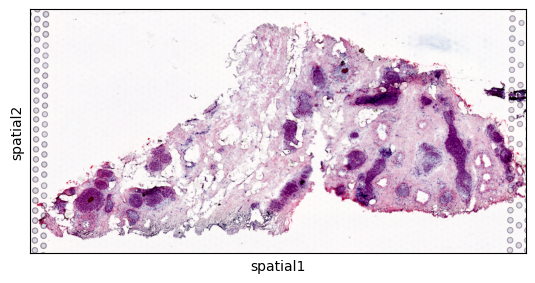

In [18]:
sc.pl.spatial(adata, img_key='hires', show=True)

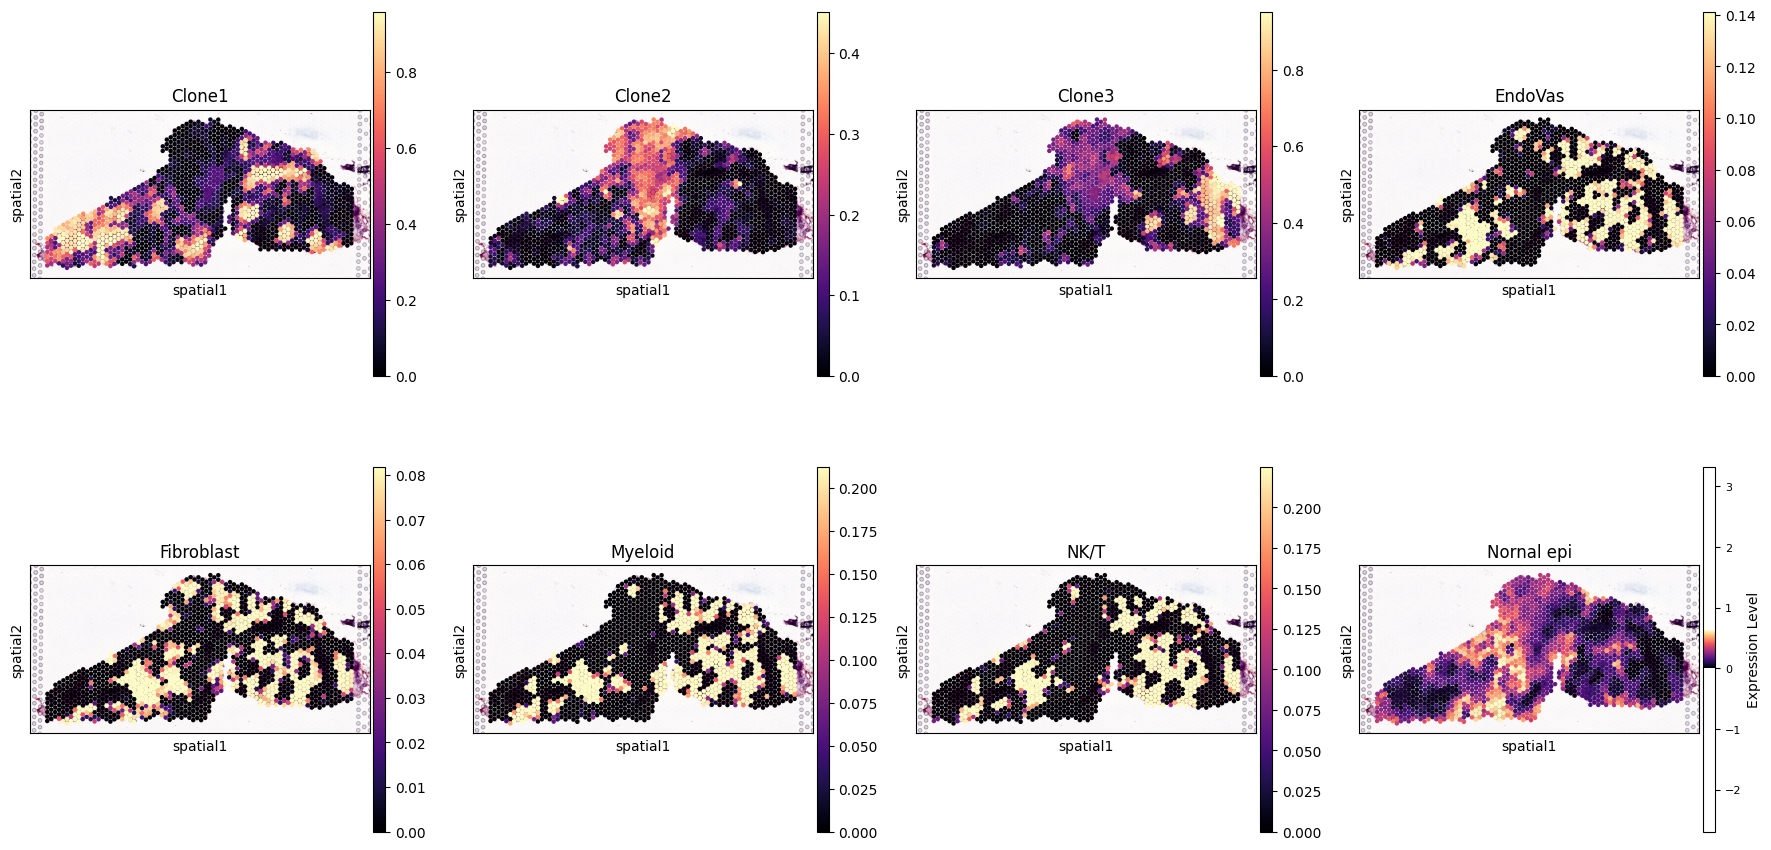

In [17]:
with mpl.rc_context({'figure.figsize': [4.5, 5]}):
    sc.pl.spatial(
        adata,
        cmap='magma',
        color=['Clone1', 'Clone2', 'Clone3', 'EndoVas', 'Fibroblast', 'Myeloid', 'NK/T', 'Nornal epi'],
        ncols=4,
        size=1.5,
        img_key='hires',
        vmin=0,
        vmax='p99.2',
        show=False  
    )
    cbar = plt.gca().collections[0].colorbar
    cbar.ax.tick_params(labelsize=8)  
    cbar.ax.set_aspect(5)  
    cbar.ax.set_ylabel('Expression Level', fontsize=10)  
    plt.show()
